## Dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, glob, json
import numpy as np
import pandas as pd
import cv2
import pickle
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [2]:
import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Data ingestion

In [3]:
data_dir = r'C:\Users\bbhagat\Documents\Datasets\pneumonia-xray\chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')
print(f'Data directory contains: {os.listdir(data_dir)}')

Data directory contains: ['sample', 'test', 'train', 'val']


## Data size validation

In [4]:
print(f'Num of Normal samples in train data = {len(os.listdir(os.path.join(train_dir, "NORMAL")))}')
print(f'Num of PNEUMONIA samples in train data = {len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))}')
print(f'Num of Normal samples in test data = {len(os.listdir(os.path.join(test_dir, "NORMAL")))}')
print(f'Num of PNEUMONIA samples in test data = {len(os.listdir(os.path.join(test_dir, "PNEUMONIA")))}')
print(f'Num of Normal samples in val data = {len(os.listdir(os.path.join(val_dir, "NORMAL")))}')
print(f'Num of PNEUMONIA samples in val data = {len(os.listdir(os.path.join(val_dir, "PNEUMONIA")))}')

Num of Normal samples in train data = 1341
Num of PNEUMONIA samples in train data = 3875
Num of Normal samples in test data = 234
Num of PNEUMONIA samples in test data = 390
Num of Normal samples in val data = 8
Num of PNEUMONIA samples in val data = 8


## Data visuals

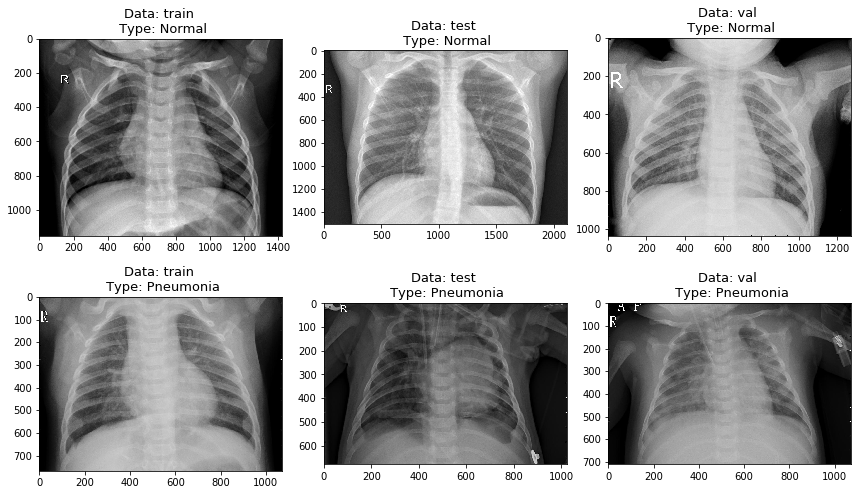

In [47]:
fig, ax = plt.subplots(2, 3, figsize = (12, 7))
ax = ax.ravel()
plt.tight_layout()

for i, set_path in enumerate([train_dir, test_dir, val_dir]):
    ax[i].imshow(plt.imread(set_path + '/NORMAL/' + os.listdir(set_path + '/NORMAL')[1]), cmap = 'gray')
    ax[i].set_title('Data: {} \n Type: Normal'.format(set_path.split('\\')[-1]), fontsize = 13)
    ax[i+3].imshow(plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA')[1]), cmap = 'gray')
    ax[i+3].set_title('Data: {} \n Type: Pneumonia'.format(set_path.split('\\')[-1]), fontsize = 13)

Normal image original size = (1152, 1422, 3)
Pneumonia image original size = (1056, 1248, 3)


Text(0.5, 1.0, 'PNEUMNIA_CLAHE')

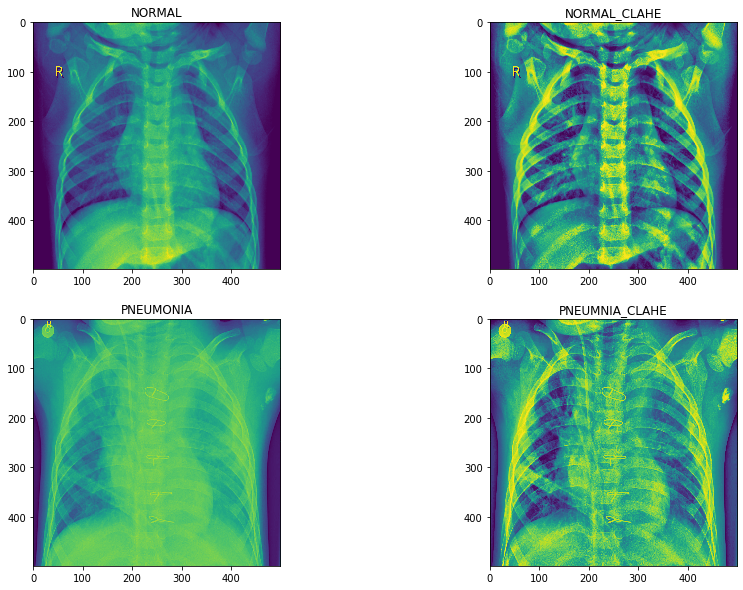

In [48]:
clahe = cv2.createCLAHE(clipLimit=5)

img_normal = cv2.imread(os.path.join(train_dir, 'NORMAL', 'IM-0117-0001.jpeg'))
print(f'Normal image original size = {img_normal.shape}')
img_normal = cv2.resize(img_normal, (500, 500))
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY)
img_normal_clahe = clahe.apply(img_normal)

img_pneumonia = cv2.imread(os.path.join(train_dir, 'PNEUMONIA', 'person3_bacteria_10.jpeg'))
print(f'Pneumonia image original size = {img_pneumonia.shape}')
img_pneumonia = cv2.resize(img_pneumonia, (500, 500))
img_pneumonia = cv2.cvtColor(img_pneumonia, cv2.COLOR_BGR2GRAY)
img_pneumonia_clahe = clahe.apply(img_pneumonia)

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0,0].imshow(img_normal)
axs[0,0].set_title("NORMAL")
axs[0,1].imshow(img_normal_clahe)
axs[0,1].set_title("NORMAL_CLAHE")
axs[1,0].imshow(img_pneumonia)
axs[1,0].set_title("PNEUMONIA")
axs[1,1].imshow(img_pneumonia_clahe)
axs[1,1].set_title("PNEUMNIA_CLAHE")

##  Data Augumentation using data generator

We need generator because training big amount of images can take us to memory insufficient error.
Here generator will do all our image processing task for training.
We will apply image augumentation only on the training images not on testing or validation.

In [121]:
img_width, img_height = (224, 224)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, width_shift_range=0.1, 
                                   height_shift_range=0.1, brightness_range=[0.4, 1.0], horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_width, img_height), batch_size=batch_size,
                                                    class_mode='binary', shuffle=True)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_width, img_height), batch_size=batch_size,
                                                    class_mode='binary')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(img_width, img_height), batch_size=batch_size,
                                                    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [122]:
sample_train_dir = os.path.join(data_dir, 'sample', 'train')
sample_test_dir = os.path.join(data_dir, 'sample', 'test')
sample_val_dir = os.path.join(data_dir, 'sample', 'val')

print(f'Num of Normal samples in sample train data = {len(os.listdir(os.path.join(sample_train_dir, "NORMAL")))}')
print(f'Num of PNEUMONIA samples in sample train data = {len(os.listdir(os.path.join(sample_train_dir, "PNEUMONIA")))}')
print(f'Num of Normal samples in sample test data = {len(os.listdir(os.path.join(sample_test_dir, "NORMAL")))}')
print(f'Num of PNEUMONIA samples in sample test data = {len(os.listdir(os.path.join(sample_test_dir, "PNEUMONIA")))}')
print(f'Num of Normal samples in sample val data = {len(os.listdir(os.path.join(sample_val_dir, "NORMAL")))}')
print(f'Num of PNEUMONIA samples in sample val data = {len(os.listdir(os.path.join(sample_val_dir, "PNEUMONIA")))}')

Num of Normal samples in sample train data = 64
Num of PNEUMONIA samples in sample train data = 64
Num of Normal samples in sample test data = 32
Num of PNEUMONIA samples in sample test data = 32
Num of Normal samples in sample val data = 8
Num of PNEUMONIA samples in sample val data = 8


In [123]:
img_width, img_height = (224, 224)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, width_shift_range=0.1, 
                                   height_shift_range=0.1, brightness_range=[0.4, 1.0], horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(sample_train_dir, target_size=(img_width, img_height), batch_size=batch_size,
                                                    class_mode='binary', shuffle=True)
test_generator = test_datagen.flow_from_directory(sample_test_dir, target_size=(img_width, img_height), batch_size=batch_size,
                                                    class_mode='binary')
val_generator = val_datagen.flow_from_directory(sample_val_dir, target_size=(img_width, img_height), batch_size=batch_size,
                                                    class_mode='binary')

Found 128 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


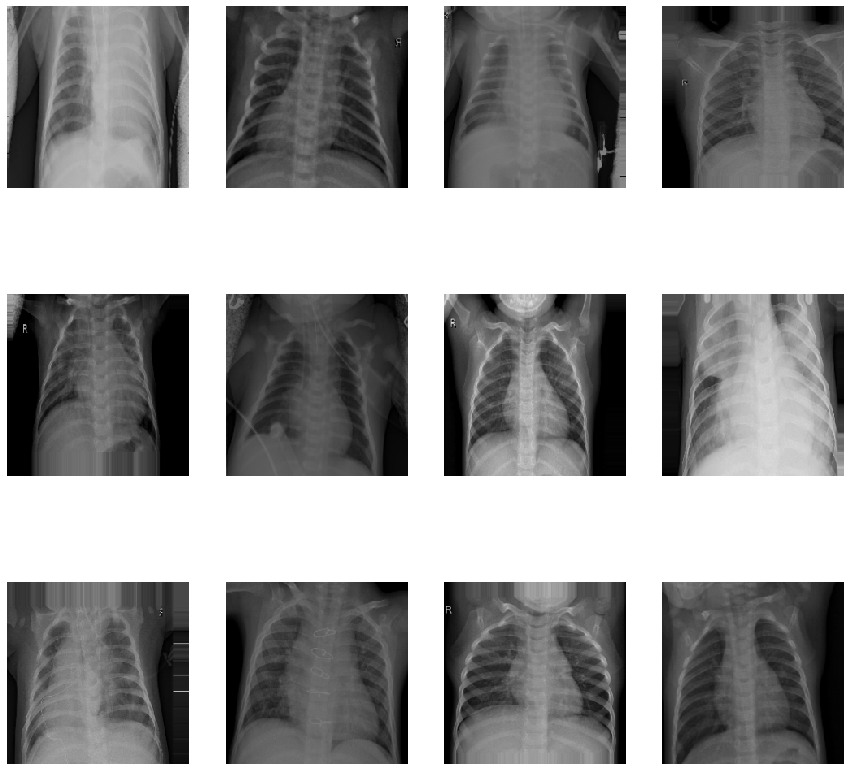

In [124]:
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15, 15))
    for n in range(12):
        ax = plt.subplot(3, 4, n + 1)
        plt.imshow(image_batch[n])
        plt.axis("off")

show_batch(image_batch, label_batch)

## Model training

In [125]:
n_train = train_generator.n
n_val = val_generator.n
n_test = test_generator.n

epochs = 20
batch_size = 16

### Densenet169

In [46]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

base = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1664)              6656      
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

In [48]:
import pydot, graphviz

In [51]:
plot_model(model, show_shapes=False)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [127]:
opt = Adam(lr=0.0001)

model.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss',
                   mode='min', 
                   min_delta=0.01,
                   patience=7, 
                   restore_best_weights=True,
                   verbose=1, 
                   baseline=None)

rlrp = ReduceLROnPlateau(monitor='val_loss', 
                         mode='min',
                         min_delta=0.01, 
                         factor=0.01, 
                         patience=3, verbose=1)

model_save = ModelCheckpoint('./models/densenet_169.h5', 
                             save_best_only=True, 
                             save_weights_only=False, 
                             monitor='val_loss', 
                             mode='min', verbose=1)

In [128]:
densenet_history = model.fit(train_generator,
                             steps_per_epoch=n_train // batch_size,
                             epochs=10,
                             validation_data=test_generator,
                             callbacks=[es, model_save, rlrp],
                             verbose=1)

Train for 8 steps, validate for 4 steps
Epoch 1/10
7/8 [=========================>....] - ETA: 13s - loss: 0.7302 - accuracy: 0.5804
Epoch 00001: val_loss improved from inf to 0.67005, saving model to ./models/densenet_169.h5
8/8 [==============================] - 130s 16s/step - loss: 0.7109 - accuracy: 0.6016 - val_loss: 0.6700 - val_accuracy: 0.5781
Epoch 2/10
7/8 [=========================>....] - ETA: 10s - loss: 0.7038 - accuracy: 0.5893
Epoch 00002: val_loss improved from 0.67005 to 0.65767, saving model to ./models/densenet_169.h5
8/8 [==============================] - 105s 13s/step - loss: 0.7774 - accuracy: 0.5469 - val_loss: 0.6577 - val_accuracy: 0.5781
Epoch 3/10
7/8 [=========================>....] - ETA: 12s - loss: 0.7217 - accuracy: 0.5982
Epoch 00003: val_loss improved from 0.65767 to 0.64603, saving model to ./models/densenet_169.h5
8/8 [==============================] - 120s 15s/step - loss: 0.7246 - accuracy: 0.5781 - val_loss: 0.6460 - val_accuracy: 0.6250
Epoch 4

## Plot training progress

In [117]:
def plot_training(history):
    
    training_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    training_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch_range = range(len(training_accuracy))
    plt.figure(10, 10)
    plt.subplot(1, 2, 1)
    plt.title('Accuracy')
    plt.plot(epoch_range, training_accuracy, label='Training Accuracy')
    plt.plot(epoch_range, val_accuracy, label='Val Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.title('Loss')
    plt.plot(epoch_range, training_loss, label='Training Loss')
    plt.plot(epoch_range, val_loss, label='Val Loss')

In [118]:
plot_training(densenet_history)

KeyError: 'val_accuracy'

In [119]:
densenet_history.history

{'loss': [0.5023129924309034], 'accuracy': [0.75038344]}

## Training Visualization and Prediction Evaluation

In [12]:
def plot_training(history):
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']
    epoch_range = range(len(train_accuracy))

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, train_accuracy, label='Training Accuracy')
    plt.plot(epoch_range, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, train_loss, label='Training Loss')
    plt.plot(epoch_range, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend(loc='upper right')
    plt.show()

In [25]:
def process_image(image):
    image = image / 255
    image = cv2.resize(image, (224, 224))
    return image

def predict_image(model, image_path):
    img = cv2.imread(image_path)
    img = np.asarray(img)
    processed_img = process_image(img)
    processed_img = np.expand_dims(processed_img, axis=0)
    print(processed_img.shape)
    pred = model.predict(processed_img)
    return pred

def testing(model, test_df):
    """ the passed data must be the img_path columns and label column"""
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict_image(model, image)[0][0])
    final_base_pred  = np.where(np.array(base_pred)>0.5,1,0)
    actual_label = test_df['label']
    # print(final_base_pred)
    print(classification_report(actual_label, final_base_pred))
    matrix=confusion_matrix(actual_label, final_base_pred)
    sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False, xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

def prep_test_data(test_dir):
    test_data = []
    test_pneumonia_path = os.path.join(test_dir, 'PNEUMONIA')
    test_normal_path = os.path.join(test_dir, 'NORMAL')

    for filename in os.listdir(test_normal_path):
        test_data.append((os.path.join(test_normal_path, filename), 0))
    for filename in os.listdir(test_pneumonia_path):
        test_data.append((os.path.join(test_pneumonia_path, filename), 1))
    test_df = pd.DataFrame(test_data, columns=['img_path', 'label'])
    return test_df

## Loading Trained Model and History

### Densenet

In [26]:
models_dir = r'C:\Users\bbhagat\Documents\Datasets\pneumonia-xray\models'

In [11]:
#densenet_model_from_disk = model.load_weights(os.path.join(models_dir, 'densenet_169.h5'))

In [27]:
densenet_model_from_disk = load_model(os.path.join(models_dir, 'densenet_169.h5'))
with open(os.path.join(models_dir, 'densenet_169_history'), 'rb') as h:
    densenet_history_from_disk = pickle.load(h)

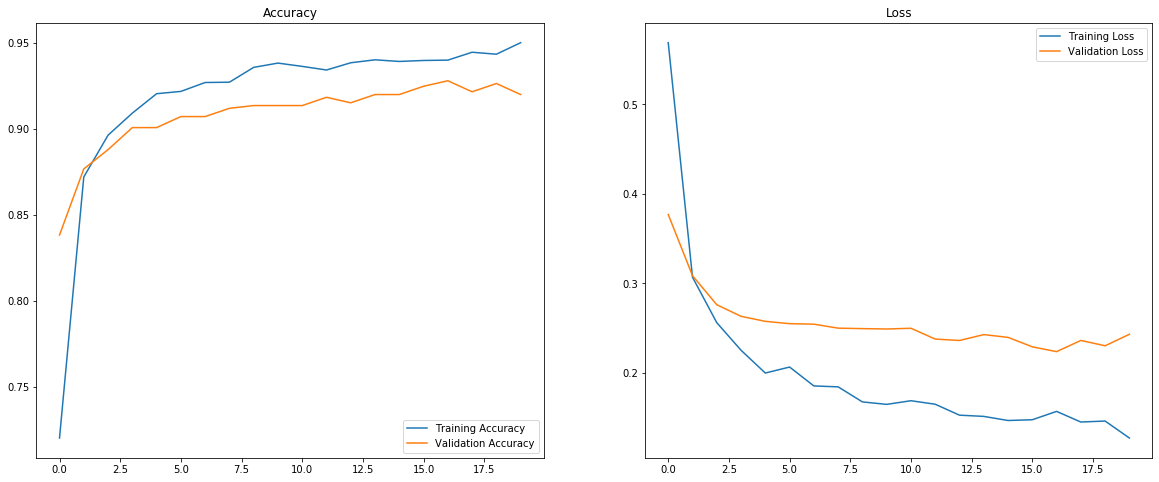

In [14]:
plot_training(densenet_history_from_disk)

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 

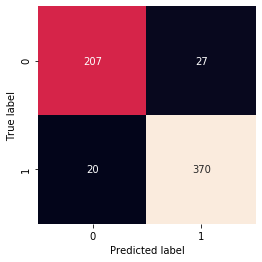

In [28]:
test_df = prep_test_data(test_dir)
testing(densenet_model_from_disk, test_df)

### Mobilenet

In [16]:
mobilenet_model_from_disk = load_model(os.path.join(models_dir, 'mobilenet.h5'))
with open(os.path.join(models_dir, 'mobilenet_history'), 'rb') as h:
    mobilenet_history_from_disk = pickle.load(h)

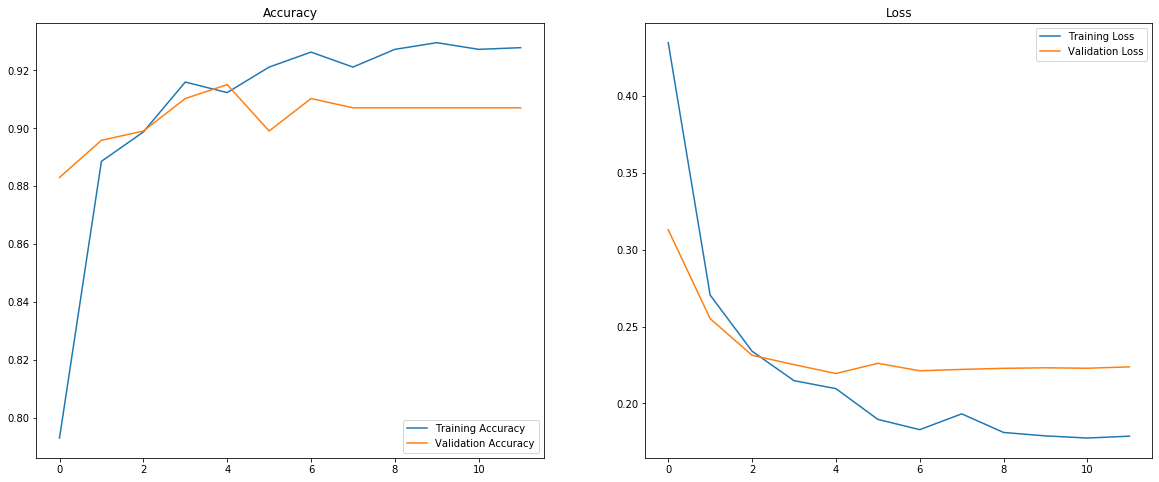

In [17]:
plot_training(mobilenet_history_from_disk)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       234
           1       0.95      0.90      0.92       390

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.90       624
weighted avg       0.91      0.91      0.91       624



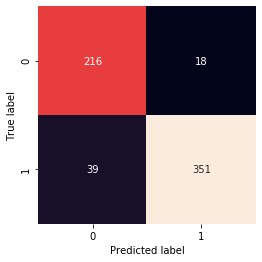

In [18]:
testing(mobilenet_model_from_disk, test_df)

### Stacked - Densenet + Mobilenet

In [22]:
stacked_model_from_disk = load_model(os.path.join(models_dir, 'stacked_mobilenet_densenet.h5'))
with open(os.path.join(models_dir, 'stacked_model_history'), 'rb') as h:
    stacked_history_from_disk = pickle.load(h)

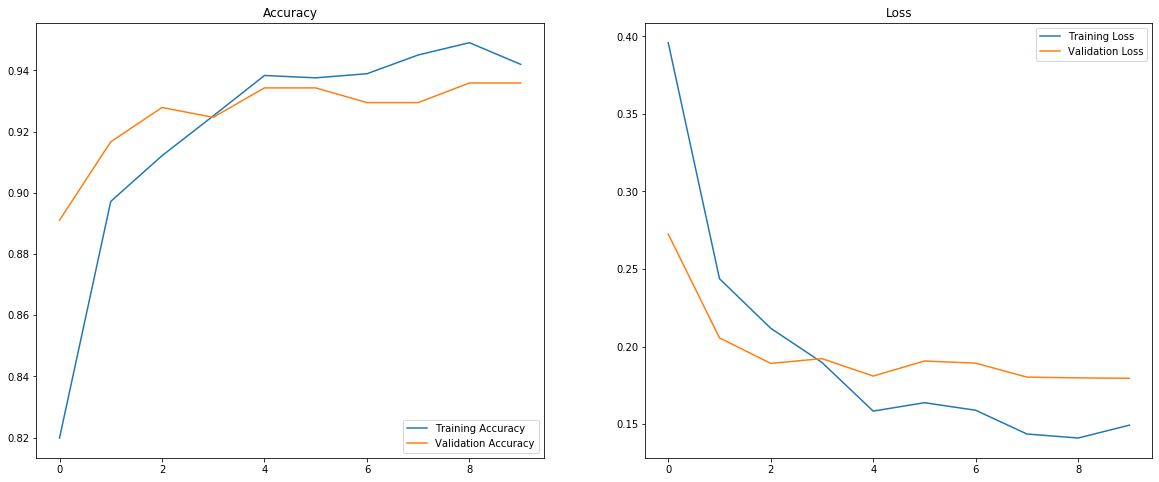

In [23]:
plot_training(stacked_history_from_disk)

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       234
           1       0.94      0.94      0.94       390

    accuracy                           0.93       624
   macro avg       0.92      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



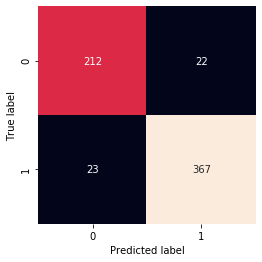

In [24]:
testing(stacked_model_from_disk, test_df)